# Procesamiento
Vamos a utilizar sklearn para el procesamiento de datos mediante pipelines.
- Buena info de cómo hacer esto aquí: https://www.youtube.com/watch?v=0B5eIE_1vpU&t=1227s

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [2]:
# Vamos a definir los datos de entrenamiento
X = train.drop(['mineralType', 'id'], axis=1)
y = train['mineralType']

In [3]:
# Create sklearn pipeline for data preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
from sklearn import set_config
import numpy as np
from sklearn import set_config
import mlflow

set_config(display='diagram')

mlflow.sklearn.autolog()

preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), StandardScaler()), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']), # convert from feet to meters
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']), # pass through the column unchanged
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
        ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
        ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
        ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", StandardScaler(), ['mineralDensity']), # pass through the column unchanged
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

model = KNeighborsClassifier()
# model = LinearSVC(random_state=0, tol=1e-05)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

grid = GridSearchCV(pipe, cv=5, scoring=['accuracy', 'precision_macro'], error_score='raise', return_train_score=True, n_jobs=-1, verbose=1, refit='accuracy',
            param_grid={
                'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                'model__weights': ['uniform', 'distance'],
                'model__metric': ['euclidean', 'manhattan']
            })

# Train the model
grid.fit(X, y)

2022/04/22 12:48:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/04/22 12:48:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bb3c53da4ee04c11b90634ae56010eee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/22 12:48:06 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('temperatureFirstHalfPlanetRotation',
                                                  Pipeline(steps=[...`


Fitting 5 folds for each of 24 candidates, totalling 120 fits


2022/04/22 12:53:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/sergio/.pyenv/versions/3.7.13/envs/fase6/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/22 12:53:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/sergio/.pyenv/versions/3.7.13/envs/fase6/lib/python3.7/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema bas

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('temperatureFirstHalfPlanetRotation',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function <lambda> at 0x7fa796027e60>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['temp...
                                                                         ['detectionDepth']),
                                                                        ('longitude',
                                                                         StandardScaler(),
                                                                         ['longitude'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__metric': ['euclidean', 'manhattan'],
                         'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                         'model__weights': ['uniform', 'distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro'], verbose=1)

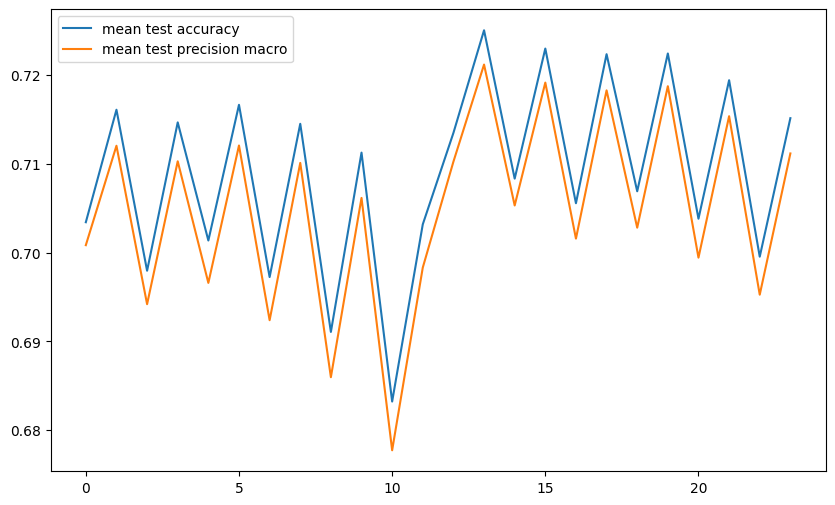

In [4]:
# Plot the results of the grid search to see which parameters are the best for the model to use
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(grid.cv_results_['mean_test_accuracy'], label='mean test accuracy')
plt.plot(grid.cv_results_['mean_test_precision_macro'], label='mean test precision macro')
plt.legend()
plt.show()

In [5]:
grid.best_params_

{'model__metric': 'manhattan',
 'model__n_neighbors': 5,
 'model__weights': 'distance'}

In [6]:
grid.best_score_

0.7250618066561013

In [7]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,split3_train_precision_macro,split4_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,0.426836,0.053579,1.969657,0.389861,euclidean,5,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.702970,0.699287,0.700475,0.701268,0.713154,0.703431,0.005007,17,0.801704,0.801129,0.803110,0.800634,0.794691,0.800254,0.002902,0.700894,0.695654,0.698182,0.696903,0.712596,0.700846,0.006126,16,0.801249,0.799896,0.801797,0.799383,0.793332,0.799131,0.003029
1,0.351811,0.040889,1.056298,0.190766,euclidean,5,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.714851,0.715927,0.713946,0.706022,0.729794,0.716108,0.007685,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.710927,0.711314,0.711325,0.700201,0.726476,0.712049,0.008377,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.326498,0.103070,1.470697,0.144385,euclidean,8,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.685545,0.702060,0.693344,0.706418,0.702456,0.697965,0.007537,21,0.772286,0.771318,0.773101,0.768050,0.769436,0.770838,0.001854,0.682106,0.697741,0.689909,0.700029,0.701188,0.694194,0.007212,21,0.771406,0.769728,0.772050,0.766093,0.767403,0.769336,0.002283
3,0.395911,0.153352,0.936408,0.156208,euclidean,8,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.707723,0.712758,0.709984,0.715135,0.727813,0.714682,0.007026,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.703673,0.708201,0.705750,0.709210,0.724660,0.710299,0.007436,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.334313,0.091258,1.487048,0.356775,euclidean,10,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.684752,0.705230,0.700079,0.704834,0.711965,0.701372,0.009132,19,0.761094,0.758047,0.760622,0.754977,0.755373,0.758022,0.002549,0.680116,0.700184,0.694460,0.697576,0.710639,0.696595,0.009871,19,0.758920,0.756024,0.758547,0.752169,0.752609,0.755654,0.002849
5,0.491076,0.241677,1.032923,0.249915,euclidean,10,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.707723,0.718304,0.712758,0.716719,0.727813,0.716663,0.006666,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.703770,0.714278,0.707718,0.710736,0.723898,0.712080,0.006847,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.370408,0.097351,1.473396,0.314878,euclidean,12,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.685941,0.691759,0.699287,0.702456,0.706815,0.697252,0.007494,22,0.752872,0.747945,0.752501,0.745073,0.746261,0.748930,0.003202,0.681672,0.685955,0.693554,0.695308,0.705461,0.692390,0.008210,22,0.750584,0.745107,0.749907,0.742158,0.743132,0.746178,0.003461
7,0.552906,0.062211,1.446997,0.225891,euclidean,12,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.708119,0.709984,0.711965,0.719493,0.723059,0.714524,0.005757,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.705004,0.704656,0.707155,0.714316,0.719442,0.710115,0.005819,11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.357594,0.075356,1.862760,0.615194,euclidean,15,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.680000,0.686609,0.687005,0.698494,0.703249,0.691071,0.008514,23,0.739600,0.736952,0.

In [8]:
preprocessed_data = preprocessor.fit_transform(X)

preprocessed_dataframe = pd.DataFrame(preprocessed_data, columns=preprocessor.get_feature_names_out())
preprocessed_dataframe

2022/04/22 12:54:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '95d9566735284bac94b0aafc694b8c99', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/22 12:54:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/22 12:54:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/22 12:54:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '13542aa22a2049858937a9de0d20e418', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/22 12:54:08 WARNING mlflow.sklearn: Training metrics

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover_1,cover_2,cover_3,cover_4,climaticZone,geoZone_1,geoZone_2,geoZone_5,geoZone_7,rockSize_1,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,-4.375851,0.062969,0.177788,-0.561392,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.372945,0.036297,-0.816631
1,0.224153,1.300463,-0.923458,-0.637252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.705677,-0.008990,2.183750
2,0.261303,0.705213,-0.924247,-0.804866,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.528747,1.170855,-1.171792
3,0.246694,-0.469623,-0.876572,-0.641185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.528747,-1.188836,-0.167580
4,0.260051,0.156956,-1.074219,-0.835997,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.501853,-0.988620,-0.429381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,0.197438,-1.111866,-0.872966,-0.673135,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.853237,1.421126,-0.462613
12617,0.256712,1.472772,0.231856,-0.178976,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.005589,0.339005,1.864209
12618,0.255459,0.767871,0.626084,-0.506668,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.528747,1.085048,-1.252170
12619,0.237510,1.300463,4.127995,2.629992,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.750731,1.256662,2.158515


In [9]:
from sklearn import set_config

set_config(display='diagram')
grid

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('temperatureFirstHalfPlanetRotation',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function <lambda> at 0x7fa796027e60>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['temp...
                                                                         ['detectionDepth']),
                                                                        ('longitude',
                                                                         StandardScaler(),
                                                                         ['longitude'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__metric': ['euclidean', 'manhattan'],
                         'model__n_neighbors': [5, 8, 10, 12, 15, 20],
                         'model__weights': ['uniform', 'distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro'], verbose=1)